## Make necessary imports

In [1]:
import sys
sys.path.insert(0, '../')
import pandas as pd
import numpy as np
np.set_printoptions(precision=3, linewidth=200, suppress=True)
from library.datasets.cifar10 import CIFAR10
from library.utils import file_utils
from library.plot_tools import plot_tools
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split as train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics as skm
from sklearn import svm
from sklearn.externals import joblib
import os, time
import matplotlib.pyplot as plt
from scipy.misc import toimage
%matplotlib inline

None


In [2]:
from sklearn.neural_network import MLPClassifier
from library.hog.hog import HOG

In [3]:
total_time = 0

## Experiment 

In [4]:
exp_no = 101
file_no = 4
data_source = 'Website'
train_validate_split = 0.2
train_validate_split_data = None
num_images_required = 1.0

In [5]:
one_hot = True
make_image = True
mode='grey'
scale_method = 'StandardScaler'

In [6]:
block_size = (8,8)
cell_size = (2,2)
nbins = 9

In [7]:
mlp_hidden_size = (5000,5000)
mlp_iterations = 10000
mlp_solver = 'adam'
mlp_alpha = 1e-5

In [8]:
param_name = 'exp_' + str(exp_no).zfill(3) + '_solver_' + mlp_solver
output_directory = '../logs/cifar10/' + str(file_no).zfill(2) + '_mlp_hog/' + 'exp_no_' + str(exp_no).zfill(3) + '/'

## Step 1.1: Load CIFAR 10 Dataset

In [9]:
start = time.time()
cifar10 = CIFAR10(one_hot_encode=one_hot, num_images=num_images_required, make_image=make_image, image_mode=mode,
                  train_validate_split=train_validate_split_data, endian='little')
cifar10.load_data(train=True, test=True, data_directory='./datasets/cifar10/')
end = time.time()
print('[ Step 0] Dataset loaded in %5.6f ms' %((end-start)*1000))
print('Dataset size: ' + str(cifar10.train.data.shape))
num_train_images = cifar10.train.data.shape[0]
total_time += (end-start)

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 50000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5
Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 2.0624 seconds
[ Step 0] Dataset loaded in 2063.434362 ms
Dataset size: (50000, 3072)


In [10]:
print('Train data shape:', cifar10.train.data.shape)
if one_hot is True:
    print('Train labels shape:', cifar10.train.one_hot_labels.shape)
if make_image is True:
    print('Train images shape:', cifar10.train.images.shape)
print('Train class labels shape:', cifar10.train.class_labels.shape)
if train_validate_split_data is not None:
    print('Validate data shape:', cifar10.validate.data.shape)
    if one_hot is True:
        print('Validate labels shape:', cifar10.validate.one_hot_labels.shape)
    if make_image is True:
        print('Validate images shape:', cifar10.vaidate.images.shape)
    print('Validate class labels shape:', cifar10.validate.class_labels.shape)
print('Test data shape:', cifar10.test.data.shape)
if one_hot is True:
    print('Test labels shape:', cifar10.test.one_hot_labels.shape)
if make_image is True:
    print('Test images shape:', cifar10.test.images.shape)
print('Test class labels shape:', cifar10.test.class_labels.shape)

Train data shape: (50000, 3072)
Train labels shape: (50000, 10)
Train images shape: (50000, 32, 32)
Train class labels shape: (50000,)
Test data shape: (10000, 3072)
Test labels shape: (10000, 10)
Test images shape: (10000, 32, 32)
Test class labels shape: (10000,)


In [11]:
print('Training images')
print(cifar10.train.data[:5])
if make_image is True and mode=='rgb':
    print('Training images rgb')
    print(cifar10.train.images[:5])
if make_image is True and mode=='float':
    print('Training images float')
    print(cifar10.train.images[:5])
if one_hot is True:
    print('Training labels')
    print(cifar10.train.one_hot_labels[:5])
print('Training classes')
print(cifar10.train.class_labels[:5])
print('Testing images')
print(cifar10.test.data[:5])
if make_image is True and mode=='rgb':
    print('Testing images rgb')
    print(cifar10.test.images[:5])
if make_image is True and mode=='float':
    print('Testing images float')
    print(cifar10.test.images[:5])
if one_hot is True:
    print('Testing labels')
    print(cifar10.test.one_hot_labels[:5])
print('Testing classes')
print(cifar10.test.class_labels[:5])

Training images
[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 [ 28  37  38 ...,  28  37  46]
 [170 168 177 ...,  82  78  80]]
Training labels
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
Training classes
[6 9 9 4 1]
Testing images
[[158 159 165 ..., 124 129 110]
 [235 231 232 ..., 178 191 199]
 [158 158 139 ...,   8   3   7]
 [155 167 176 ...,  50  52  50]
 [ 65  70  48 ..., 136 146 117]]
Testing labels
[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]
Testing classes
[3 8 8 0 6]


In [12]:
start = time.time()
data_hog = []
feature_size = 0
hog = HOG(block_size=block_size, cell_size=cell_size, nbins=nbins)
print('Generating HOG features for %d data images' %cifar10.train.images.shape[0])
for fig_num in range(cifar10.train.images.shape[0]):
    img = cifar10.train.images[fig_num, :]
    gradients = hog.make_hog_gradients(img.astype('uint8'))
    data_hog.append(gradients.flatten())
    feature_size = gradients.size
data_hog = np.array(data_hog)
print('HOG Features for data: ' + str(data_hog.shape))
end = time.time()
print('Generated HOG for train images in %.6f ms' %((end-start)*1000))

Generating HOG features for 50000 data images
HOG Features for data: (50000, 2304)
Generated HOG for train images in 39779.977798 ms


## Step 1.2: Load CIFAR 10 Test HOG Dataset

In [13]:
start = time.time()
test_hog = []
feature_size = 0
print('Generating HOG features for %d test images' %cifar10.test.images.shape[0])
for fig_num in range(cifar10.test.images.shape[0]):
    img = cifar10.test.images[fig_num, :]
    gradients = hog.make_hog_gradients(img.astype('uint8'))
    test_hog.append(gradients.flatten())
    feature_size = gradients.size
test_hog = np.array(test_hog)
print('HOG Features for test: ' + str(test_hog.shape))
end = time.time()
print('Generated HOG for test images in %.6f ms' %((end-start)*1000))

Generating HOG features for 10000 test images
HOG Features for test: (10000, 2304)
Generated HOG for test images in 7872.795820 ms


Plotting CIFAR 10 Train Dataset


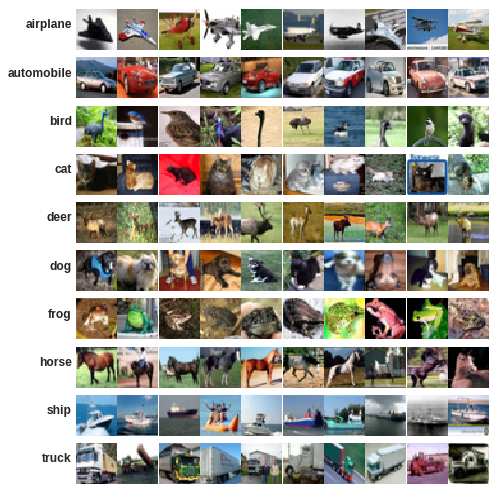

Plotting CIFAR 10 Test Dataset


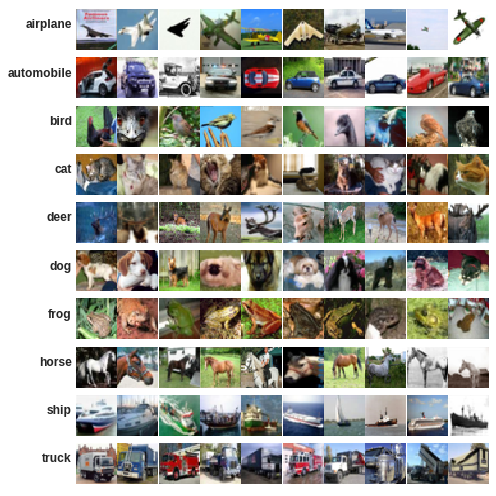

In [14]:
cifar10.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))

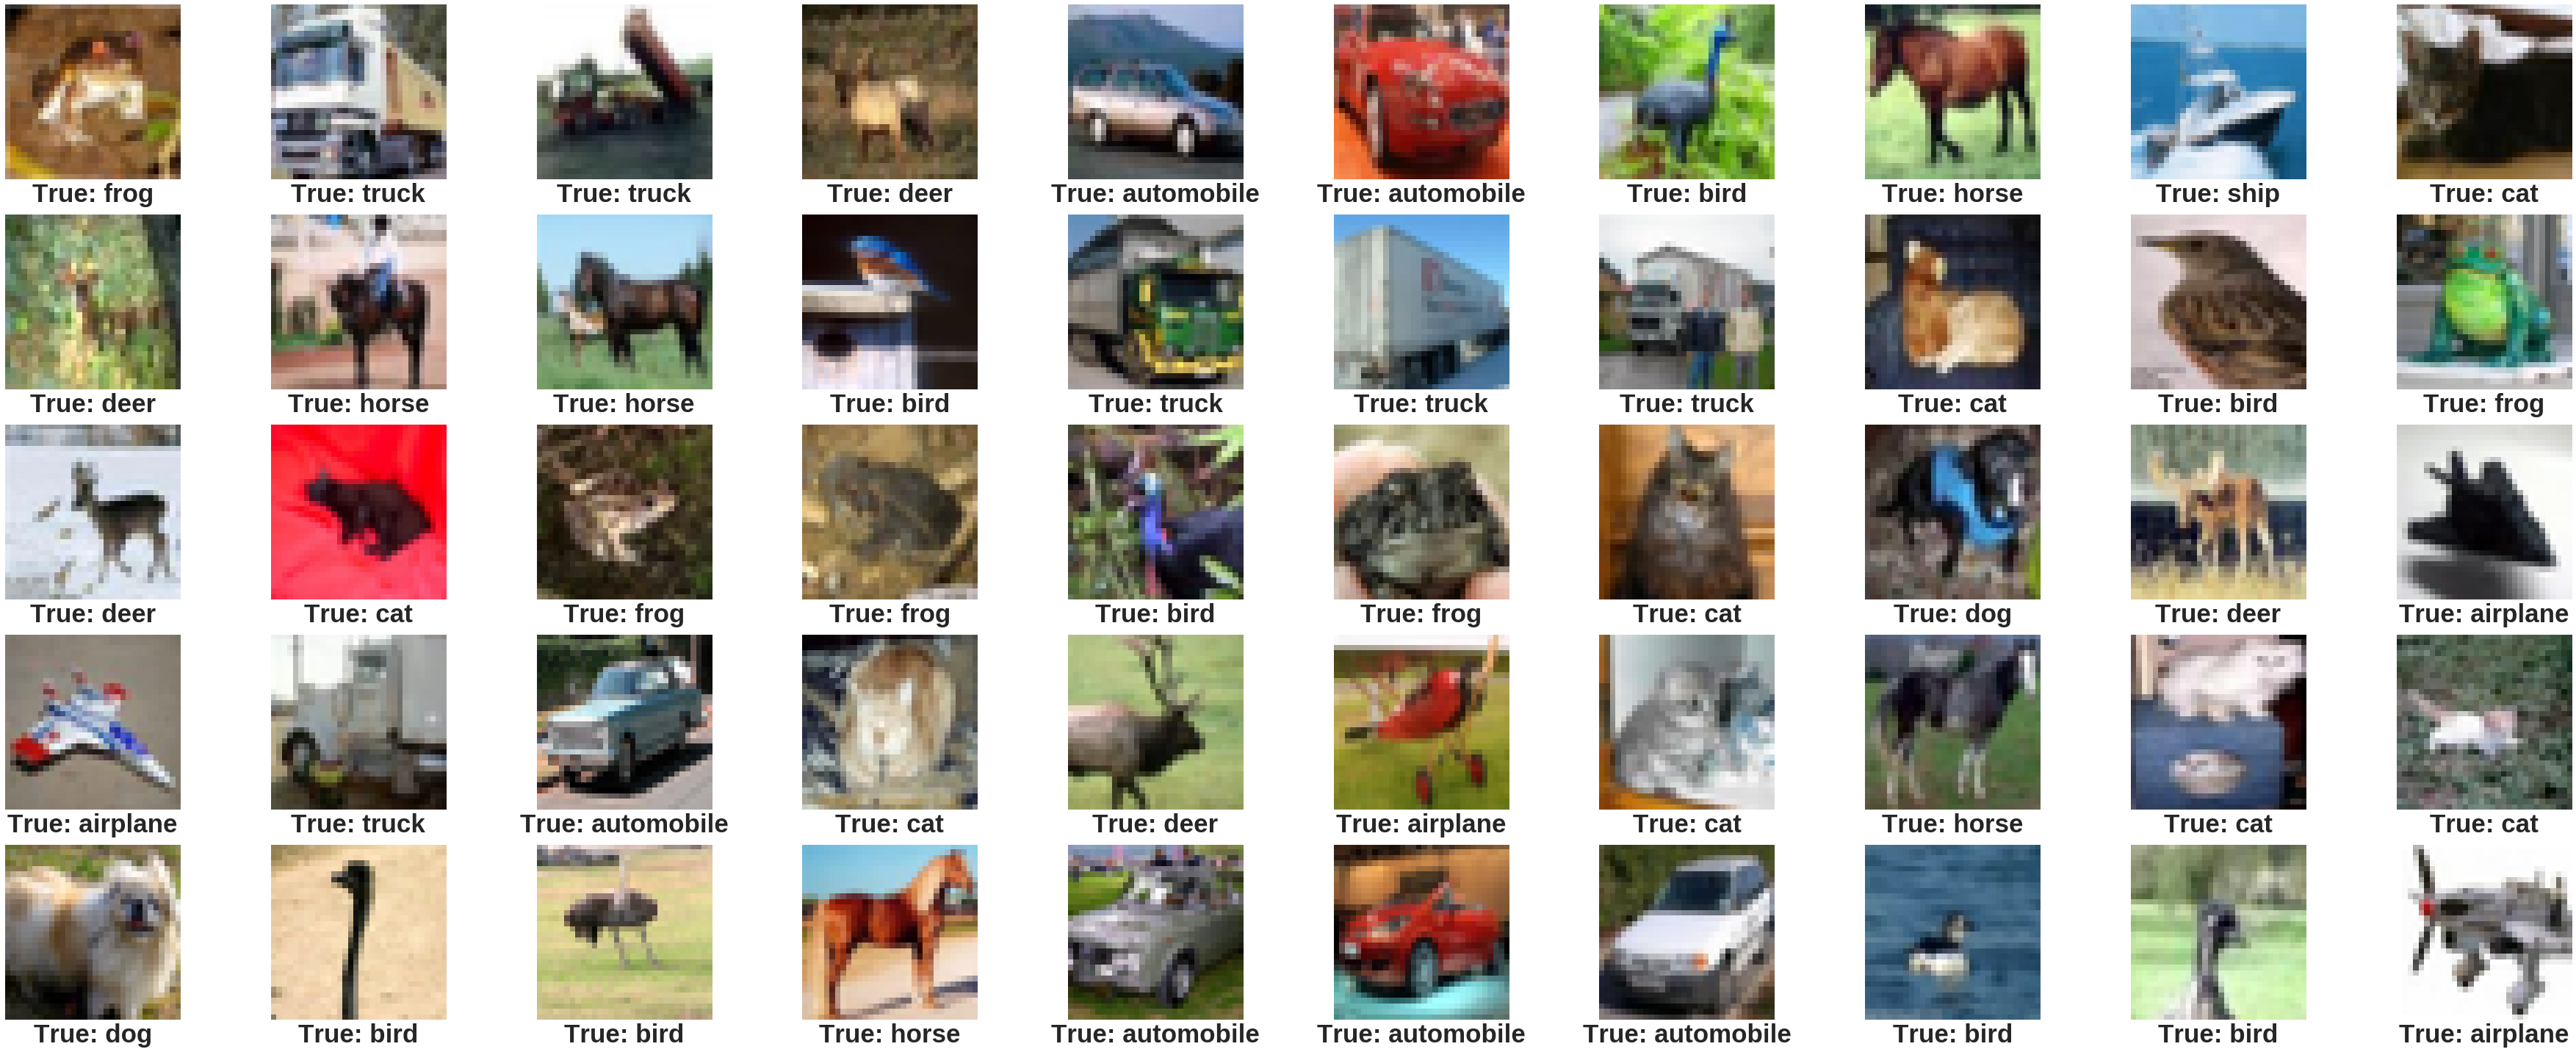

True

In [15]:
cifar10.plot_images(cifar10.train.data[:50, :], cifar10.train.class_names[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=True)

## Step 2: Preprocess data

In [16]:
start = time.time()
if scale_method == 'StandardScaler':
    ss = StandardScaler()
elif scale_method == 'MinMaxScaler':
    ss = MinMaxScaler()
else:
    ss = StandardScaler()
data_images = ss.fit_transform(data_hog)
test_images = ss.fit_transform(test_hog)
end = time.time()
print('[ Step 2] Dataset transformations done in %.6f ms' %((end-start)*1000))
print('Training the classifier on %d images' % num_train_images)
print('Dataset size: ' + str(cifar10.train.data.shape))
total_time += (end-start)

[ Step 2] Dataset transformations done in 1808.086634 ms
Training the classifier on 50000 images
Dataset size: (50000, 3072)


## Step 3: Train Test Split of data

In [17]:
start = time.time()
X_train, X_test, y_train, y_test = train_test_split(data_images, cifar10.train.class_labels, 
                                                    test_size=train_validate_split)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print('Train set shape         : ' + str(X_train.shape))
print('Train labels shape      : ' + str(y_train.shape))
print('Validation set shape    : ' + str(X_test.shape))
print('Validation labels shape : ' + str(y_test.shape))
end = time.time()
print('[ Step 3] Train-test split done in %.6f ms' %((end-start)*1000))
total_time += (end-start)

Train set shape         : (40000, 2304)
Train labels shape      : (40000,)
Validation set shape    : (10000, 2304)
Validation labels shape : (10000,)
[ Step 3] Train-test split done in 434.162140 ms


## Step 4: Initiate Multi Layer Perceptron Classifier

In [18]:
start = time.time()
clf = MLPClassifier(solver=mlp_solver, alpha=mlp_alpha, hidden_layer_sizes=mlp_hidden_size, random_state=1, 
                    max_iter=mlp_iterations, verbose=True)
print(clf)
end = time.time()
print('[ Step 4] Made the Multi layer perceptron classifier in %.6f ms' %((end-start)*1000))
total_time += (end-start)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5000, 5000), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)
[ Step 4] Made the Multi layer perceptron classifier in 0.534058 ms


## Step 5: Generate the MLP Model using the train data

In [19]:
start = time.time()
print(X_train.shape)
print(y_train.shape)
clf.fit(X_train, y_train)
end = time.time()
print('[ Step 5] Made the model in %.6f ms' %((end-start)*1000))
total_time += (end-start)

(40000, 2304)
(40000,)
Iteration 1, loss = 1.85949341
Iteration 2, loss = 1.19725022
Iteration 3, loss = 1.07694064
Iteration 4, loss = 0.96341363
Iteration 5, loss = 0.87288315
Iteration 6, loss = 0.77968329
Iteration 7, loss = 0.69946882
Iteration 8, loss = 0.61778040
Iteration 9, loss = 0.54285042
Iteration 10, loss = 0.47680585
Iteration 11, loss = 0.43360785
Iteration 12, loss = 0.36459979
Iteration 13, loss = 0.32090246
Iteration 14, loss = 0.33108925
Iteration 15, loss = 0.29368334
Iteration 16, loss = 0.25900848
Iteration 17, loss = 0.22002835
Iteration 18, loss = 0.23670052
Iteration 19, loss = 0.21083473
Iteration 20, loss = 0.19372063
Iteration 21, loss = 0.20505195
Iteration 22, loss = 0.19820624
Iteration 23, loss = 0.16962748
Iteration 24, loss = 0.18156790
Iteration 25, loss = 0.16788979
Iteration 26, loss = 0.19055629
Iteration 27, loss = 0.16170721
Iteration 28, loss = 0.14208515
Iteration 29, loss = 0.18070795
Iteration 30, loss = 0.15084000
Iteration 31, loss = 0.160

## Step 6: Write the obtained model to file for further use

In [20]:
start = time.time()
file_utils.mkdir_p(output_directory)
model_output_path = output_directory + '04_' + param_name + '.pkl'
joblib.dump(clf, model_output_path)
end = time.time()
print('[ Step 6] Write obtained model to %s in %.6f ms' %(model_output_path, ((end-start)*1000)))
total_time += (end-start)

[ Step 6] Write obtained model to ../logs/cifar10/04_mlp_hog/exp_no_101/04_exp_101_solver_adam.pkl in 15435.679674 ms


## Step 7: Do the prediction on validation set

Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Confusion matrix, without normalization
[[620  34  83  43  59  24  17  35  67  49]
 [ 21 742  18  26  25  12  21   6  36  93]
 [ 68  14 511  83 121  86  52  39  28  15]
 [ 12  16  96 371 102 227  55  66  20  38]
 [ 25   7 106 103 535  80  31  64  24  24]
 [  9   8  70 195 101 477  43  69   7  19]
 [ 10  17  55  64  97  60 641  10   9  12]
 [ 13   8  62  74 115 111  21 573   8  33]
 [ 88  89  35  23  28  14  25  20 557  74]
 [ 24  91  17  37  45  24  13  22  37 696]]
Normalized confusion matrix
[[ 0.601  0.033  0.081  0.042  0.057  0.023  0.016  0.034  0.065  0.048]
 [ 0.021  0.742  0.018  0.026  0.025  0.012  0.021  0.006  0.036  0.093]
 [ 0.067  0.014  0.502  0.082  0.119  0.085  0.051  0.038  0.028  0.015]
 [ 0.012  0.016  0.096  0.37   0.102  0.226  0.055  0.066  0.02   0.038]
 [ 0.025  0.007  0.106  0.103  0.536  0.08   0.031  0.064  0.024  0.024]
 [ 0.009  0.008  0.07   0.195  0.101  0.478  0.043  0.069  0.007  0.019]
 [ 0.01   0.017  0.056  

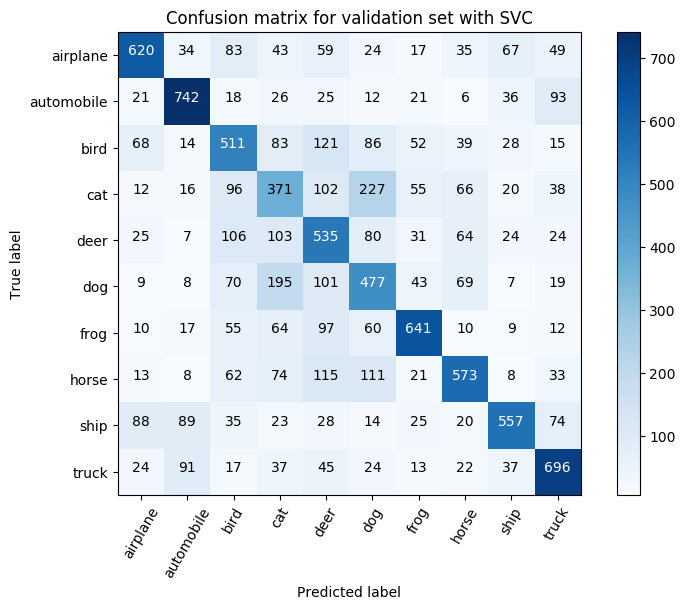

[ Step 7] Make prediction on validation dataset in 18523.382187 ms


In [21]:
y_predict = clf.predict(X_test)
labels = sorted(list(set(cifar10.train.class_labels)))
print('Labels: ' + str(labels))
plot_tools.plot_confusion_matrix(y_test, y_predict, classes=cifar10.classes, fig_size=(8,6),
                              normalize=True, title='Confusion matrix for validation set with MLP')
end = time.time()
print('[ Step 7] Make prediction on validation dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

## Step 8: Generate the Classification report for validation data

In [22]:
start = time.time()
print('Classification report:')
print(skm.classification_report(y_test, y_predict, target_names=cifar10.classes))
validate_accuracy = skm.accuracy_score(y_test, y_predict, normalize=True)
print('Validation accuracy score: ' + str(validate_accuracy))
end = time.time()
print('[ Step 8] Generating classification on validation dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

Classification report:
             precision    recall  f1-score   support

   airplane       0.70      0.60      0.65      1031
 automobile       0.72      0.74      0.73      1000
       bird       0.49      0.50      0.49      1017
        cat       0.36      0.37      0.37      1003
       deer       0.44      0.54      0.48       999
        dog       0.43      0.48      0.45       998
       frog       0.70      0.66      0.68       975
      horse       0.63      0.56      0.60      1018
       ship       0.70      0.58      0.64       953
      truck       0.66      0.69      0.68      1006

avg / total       0.58      0.57      0.58     10000

Validation accuracy score: 0.5723
[ Step 8] Generating classification on validation dataset in 5.753279 ms


## Step 9: Generate the predictions on test data set

In [23]:
start = time.time()
prediction_numbers = clf.predict(test_images)
prediction_classes = []
num_test_images = test_hog.shape[0]
for i in range(num_test_images):
    prediction_classes.append(cifar10.classes[int(prediction_numbers[i])])
end = time.time()
print('[ Step 9] Make prediction on test dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

[ Step 9] Make prediction on test dataset in 2427.993774 ms


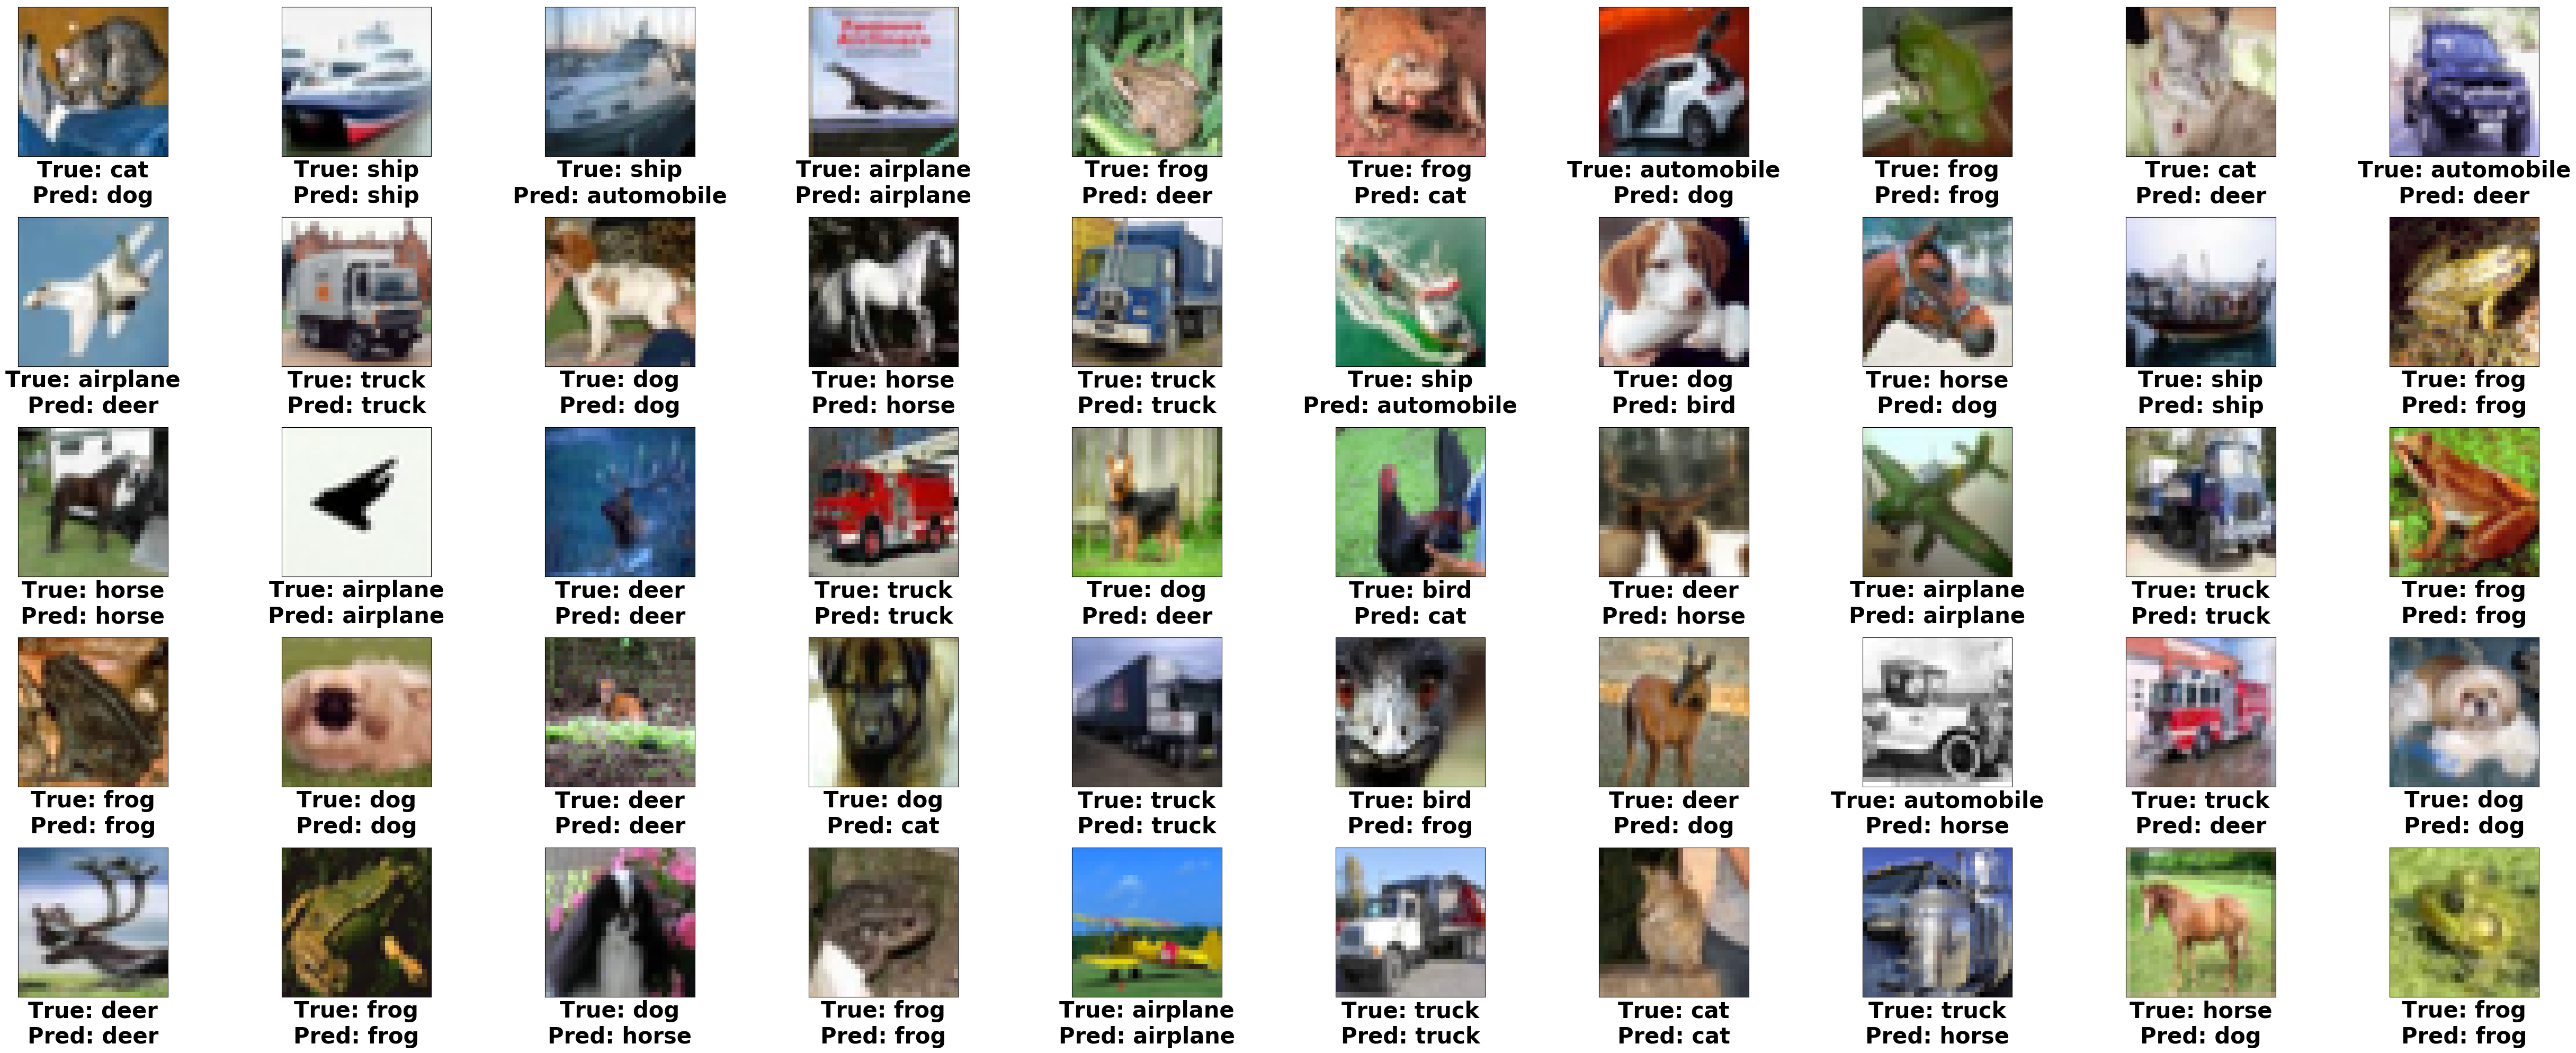

True

In [24]:
cifar10.plot_images(cifar10.test.data[:50], cifar10.test.class_names[:50], cls_pred=prediction_classes[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=30, convert=True)

## Step 10: Print the accuracy score of the classifier

Confusion matrix, without normalization
[[564  26  92  52  62  20  26  25  96  37]
 [ 19 731  18  14  25  19  24   7  39 104]
 [ 48  14 475 100 145  93  42  44  24  15]
 [ 28  12 101 343 147 201  65  52  15  36]
 [ 14   7  95  88 565  86  45  58  15  27]
 [ 11   8  86 194  92 477  46  71   6   9]
 [  8  21  63  75  95  53 650  12  10  13]
 [  9   9  68  72 106 112  10 571   9  34]
 [ 93 119  37  25  34  16  23  21 552  80]
 [ 29  73  20  34  31  19  13  20  37 724]]
Normalized confusion matrix
[[ 0.564  0.026  0.092  0.052  0.062  0.02   0.026  0.025  0.096  0.037]
 [ 0.019  0.731  0.018  0.014  0.025  0.019  0.024  0.007  0.039  0.104]
 [ 0.048  0.014  0.475  0.1    0.145  0.093  0.042  0.044  0.024  0.015]
 [ 0.028  0.012  0.101  0.343  0.147  0.201  0.065  0.052  0.015  0.036]
 [ 0.014  0.007  0.095  0.088  0.565  0.086  0.045  0.058  0.015  0.027]
 [ 0.011  0.008  0.086  0.194  0.092  0.477  0.046  0.071  0.006  0.009]
 [ 0.008  0.021  0.063  0.075  0.095  0.053  0.65   0.012  0.01

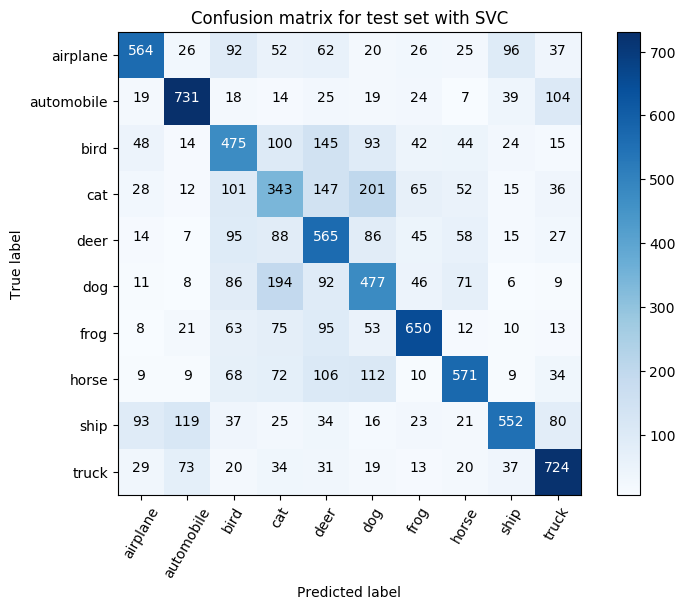

             precision    recall  f1-score   support

   airplane       0.69      0.56      0.62      1000
 automobile       0.72      0.73      0.72      1000
       bird       0.45      0.47      0.46      1000
        cat       0.34      0.34      0.34      1000
       deer       0.43      0.56      0.49      1000
        dog       0.44      0.48      0.46      1000
       frog       0.69      0.65      0.67      1000
      horse       0.65      0.57      0.61      1000
       ship       0.69      0.55      0.61      1000
      truck       0.67      0.72      0.70      1000

avg / total       0.58      0.57      0.57     10000

Accuracy score on test data: 0.5652


In [25]:
start = time.time()
plot_tools.plot_confusion_matrix(cifar10.test.class_labels, prediction_numbers, classes=cifar10.classes,
                              normalize=True, title='Confusion matrix for test set with MLP')
print(skm.classification_report(cifar10.test.class_labels, prediction_numbers, target_names=cifar10.classes))
test_accuracy = skm.accuracy_score(cifar10.test.class_labels, prediction_numbers, normalize=True)
print('Accuracy score on test data: ' + str(test_accuracy))
end = time.time()
total_time += (end-start)

In [26]:
start = time.time()
print('Prediction done on %d images' %test_images.shape[0])
print('Accuracy of the classifier: %.4f' %clf.score(test_images, cifar10.test.class_labels))
end = time.time()

Prediction done on 10000 images
Accuracy of the classifier: 0.5652


## Step 11: Write the predictions to CSV file

In [27]:
start = time.time()
indices = np.arange(1, test_images.shape[0]+1)
predictions = np.column_stack((indices, prediction_classes))
file_utils.mkdir_p(output_directory)
output_csv_file = output_directory + '04_' + param_name + '.csv'
column_names = ['id', 'label']
predict_test_df = pd.DataFrame(data=predictions, columns=column_names)
predict_test_df.to_csv(output_csv_file, index=False)
end = time.time()
print('[ Step 11] Writing the test data to file: %s in %.6f ms' %(output_csv_file, (end-start)*1000))
total_time += (end-start)

[ Step 11] Writing the test data to file: ../logs/cifar10/04_mlp_hog/exp_no_101/04_exp_101_solver_adam.csv in 85.922956 ms


In [28]:
print('Code took %.6f s to run on training with %d examples' % (total_time,num_train_images))

Code took 8496.449770 s to run on training with 50000 examples


## Print parameters for record

In [29]:
print('| %d | ' %exp_no, end='')
print('%d | '%num_train_images, end='')
print('Hidden layers size = %s, Max. Iterations: %d, Alpha: %.6f, Solver: %s, Random state: 1 | ' 
      %(str(mlp_hidden_size), mlp_iterations, mlp_alpha, mlp_solver), end='')
print('[Link](%s) | ' %output_csv_file, end='')
print('%.4f | ' %validate_accuracy, end='')
print('%.4f | ' %test_accuracy, end='')
print('%s | ' %data_source, end='')
print('[Link](%s) |' %model_output_path)

| 101 | 50000 | Hidden layers size = (5000, 5000), Max. Iterations: 10000, Alpha: 0.000010, Solver: adam, Random state: 1 | [Link](../logs/cifar10/04_mlp_hog/exp_no_101/04_exp_101_solver_adam.csv) | 0.5723 | 0.5652 | Website | [Link](../logs/cifar10/04_mlp_hog/exp_no_101/04_exp_101_solver_adam.pkl) |


## Step 12: Print notebook to HTML file

In [30]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [31]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

<IPython.core.display.Javascript object>

In [32]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [33]:
current_file = './' + theNotebook + '.ipynb'
output_file = output_directory + str(file_no).zfill(2) + '_exp_no_' + str(exp_no) + '_' + theNotebook + '.html'
print('Current file: ' + str(current_file))
print('Output file: ' + str(output_file))
file_utils.mkdir_p(output_directory) 
output_HTML(current_file, output_file)

NameError: name 'theNotebook' is not defined

In [ ]:
print('Code took %.6f s to run on training with %d examples' % (total_time,num_train_images))